In [1]:
import sys
sys.path.append('./')
sys.path.append('/home/feldheimlab/Documents/pySEAS/')

# key python packages
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler

#new name?
import wholeBrainClassify as wbc

# plt.style.use('publication')
dataset_path = '/media/feldheimlab/DF Transfer/misc - IS THIS YOURS/p21_20m/'
plt.rcParams['font.size'] = 8

save = False
save_dir = '/home/feldheimlab/Desktop/figures/'

## Load training dataset to see how well it performs on classification

In [2]:
path='./data/'
classMetricsPath = path + 'training_dataset.tsv'

domain_vars =['spatial_min', 'spatial_max', 
              'region_minaxis', 'threshold_area', 'region_extent', 'threshold_perc', 'region_majaxis', 'region_majmin_ratio', 
              'temporal_min', 
              'freq_rangesz']

try:
    main_data = pd.read_csv(classMetricsPath, sep = '\t', index_col='exp_ic')
    print('Importing dataframe\n------------------------------------')
    #renaming the columns
    neural_dict = {}
    
    for col in main_data.columns:
        if "." in col:
            new_col = col.replace(".", "_")
            neural_dict[col] = new_col

    main_data = main_data.rename(columns=neural_dict)
    print(main_data.head())
except Exception as e:
    main_data = pd.DataFrame()
    print('Error importing dataFrame')
    print('\t ERROR : ', e)
    assert not main_data.empty, 'Check path to metrics dataframe'

    
droplist = ['anml','artifact','signal','age', 'length', 'spatial_COMdom_x', 
            'spatial_COMdom_y', 'mass_perc', 'mass_region','mass_total']
try:
    main_data = main_data.fillna(value=0).copy()
    data = main_data.drop(droplist, axis=1).copy()
except Exception as e:
    data = _main_data.fillna(value=0).copy()
    print(e)
    
scaler = StandardScaler()
scaler.fit(data.values)
data[:] = scaler.transform(data.values)

print(data.isnull().sum())
print(main_data['signal'].isnull().sum())

Importing dataframe
------------------------------------
                   age  freq_avgsnr  freq_integrate  freq_maxsnr  \
exp_ic                                                             
190408_03-04-0000   22     1.193897        0.006304     1.327806   
190408_03-04-0001   22     1.422100        0.120683     1.620314   
190408_03-04-0002   22     1.296523        0.107689     1.513039   
190408_03-04-0003   22     1.172093        0.179745     1.306229   
190408_03-04-0004   22     2.093038        0.589769     3.606708   

                   freq_maxsnr_freq  freq_range_high  freq_range_low  \
exp_ic                                                                 
190408_03-04-0000          4.204482         4.585020        2.973018   
190408_03-04-0001          4.585020         0.005325        0.004883   
190408_03-04-0002          4.585020         0.005325        0.004883   
190408_03-04-0003          2.973018         0.963882        0.371627   
190408_03-04-0004          3.24209

### Iterate through and see how well the training subsets perform in model development

In [3]:
score = []
precision = []
recall = []
signal = []
artifact = []

truep =[]
truen =[]
falsep = []
falsen = []

clas = main_data.loc[:,'artifact'].copy()
clas = np.abs(clas - 1)

n_iter = 1000

rnd_clf = RandomForestClassifier(n_estimators = 40, max_features = 2)
for i in range(n_iter): # 1000 iterations of models
    Xlen = len(main_data)
    if i%50==0:
        print('Working on iteration number {}'.format(i))
    X_train, X_test, y_train, y_test = wbc.splitData(data.loc[:,domain_vars].copy(),clas)

    rnd_clf.fit(X_train, y_train)
    y_pred = rnd_clf.predict(X_test)
    y_pred_2 = rnd_clf.predict(X_train)
    
    rnd_score = rnd_clf.score(X_test, y_test)
    rnd_precision =  precision_score(y_test, y_pred)
    rnd_recall = recall_score(y_test, y_pred)
    rnd_signal = (np.sum(((y_pred==1) & (y_test==1))))/(np.sum((y_test==1)))
    rnd_artifact = (np.sum(((y_pred==0) & (y_test==0))))/(np.sum(y_test==0))

    truep.append(np.sum(y_pred[y_test==1]==y_test[y_test==1]) + np.sum(y_pred_2[y_train==1]==y_train[y_train==1]))
    truen.append(np.sum(y_pred[y_test==0]==y_test[y_test==0]) + np.sum(y_pred_2[y_train==0]==y_train[y_train==0]))
    falsen.append(np.sum(y_pred[y_test==1]!=y_test[y_test==1]) + np.sum(y_pred_2[y_train==1]!=y_train[y_train==1]))
    falsep.append(np.sum(y_pred[y_test==0]!=y_test[y_test==0]) + np.sum(y_pred_2[y_train==0]!=y_train[y_train==0]))

    score.append(rnd_score)
    precision.append(rnd_precision)
    recall.append(rnd_recall)


Working on iteration number 0
Working on iteration number 50
Working on iteration number 100
Working on iteration number 150
Working on iteration number 200
Working on iteration number 250
Working on iteration number 300
Working on iteration number 350
Working on iteration number 400
Working on iteration number 450
Working on iteration number 500
Working on iteration number 550
Working on iteration number 600
Working on iteration number 650
Working on iteration number 700
Working on iteration number 750
Working on iteration number 800
Working on iteration number 850
Working on iteration number 900
Working on iteration number 950


### Random subsets of training dataset, False positive/negative rates

The model has low false positive/negative rates for 7 animals.  

Conclusion:  A model based on these 7 mice will most likely be effective in proper classification


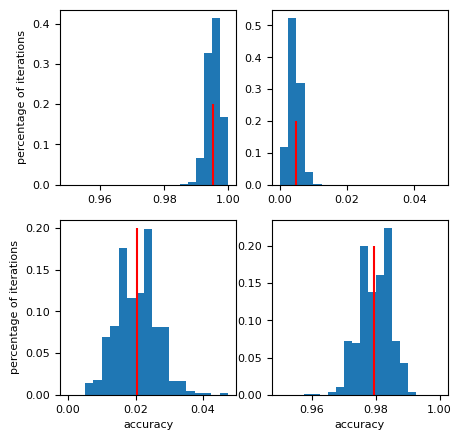


Accuracy of neural: 
True positive (neural):  0.9952364351717403
False positive (i.e. artifact but classified neural):  0.004763564828259649

Accuracy of artifact: 
True negative (artifact):  0.979608126837938
False negative (i.e. neural but classified artifact):  0.020391873162062004


In [4]:
fig, axs = plt.subplots(2,2, figsize = (5, 5))
nbin = 15

falsebins = np.arange(0, .05, .05/20)
truebins = np.arange(0.95, 1., .05/20)

average_tp = np.mean(truep)+np.mean(falsep)
axs[0][0].hist(truep/average_tp,
               bins = truebins, weights=np.ones(n_iter)/n_iter)
axs[0][0].vlines(np.mean(truep)/average_tp, 
                 ymin= 0, ymax = 0.2, color='red')
axs[0][0].set_ylabel('percentage of iterations')

average_tn = np.mean(truen)+np.mean(falsen)
axs[1][1].hist(truen/average_tn, 
               bins = truebins, weights=np.ones(n_iter)/n_iter)
axs[1][1].vlines(np.mean(truen)/average_tn, 
                 ymin= 0, ymax = .2, color='red')
axs[1][1].set_xlabel('accuracy')

axs[0][1].hist(falsep/average_tp, 
               bins = falsebins, weights=np.ones(n_iter)/n_iter) #top right
axs[0][1].vlines(np.mean(falsep)/(np.mean(truep)+np.mean(falsep)), 
                 ymin= 0, ymax = .2, color='red')

axs[1][0].hist(falsen/average_tn, 
               bins = falsebins, weights=np.ones(n_iter)/n_iter) #bottom left
axs[1][0].vlines(np.mean(falsen)/average_tn, 
                 ymin= 0, ymax = .2, color='red')
axs[1][0].set_xlabel('accuracy')
axs[1][0].set_ylabel('percentage of iterations')

plt.show()

print('\nAccuracy of neural: ')
print('True positive (neural): ', np.mean(truep)/average_tp)
print('False positive (i.e. artifact but classified neural): ', np.mean(falsep)/average_tp)

print('\nAccuracy of artifact: ')
print('True negative (artifact): ', np.mean(truen)/average_tn)
print('False negative (i.e. neural but classified artifact): ', np.mean(falsen)/average_tn)

## Test novel dataset on model trained on the full training dataset

In [5]:
classMetricsPath = path + 'novel_dataset.tsv'

try:
    novel_data = pd.read_csv(classMetricsPath, sep = '\t', index_col='exp_ic')
    print('Importing dataframe\n------------------------------------')
    #renaming the columns
    neural_dict = {}
    
    for col in novel_data.columns:
        if "." in col:
            new_col = col.replace(".", "_")
            neural_dict[col] = new_col

    novel_data = novel_data.rename(columns=neural_dict)
    print(novel_data.head())
except Exception as e:
    novel_data = pd.DataFrame()
    print('Error importing dataFrame')
    print('\t ERROR : ', e)
    assert not novel_data.empty, 'Check path to metrics dataframe'

    
droplist = ['anml','artifact','signal','age', 'length', 'spatial_COMdom_x', 
            'spatial_COMdom_y', 'mass_perc', 'mass_region','mass_total']
try:
    novel_data = novel_data.fillna(value=0).copy()
    test_data = novel_data.drop(droplist, axis=1).copy()
except Exception as e:
    print(e)

scaler = StandardScaler()
scaler.fit(test_data.values)
test_data[:] = scaler.transform(test_data.values)

print(test_data.head())

print(test_data.isnull().sum())
print(novel_data['signal'].isnull().sum())

Importing dataframe
------------------------------------
                   age  freq_avgsnr  freq_integrate  freq_maxsnr  \
exp_ic                                                             
190408_07-08-0000   22          NaN             NaN          NaN   
190408_07-08-0001   22     1.061946        0.028321     1.103959   
190408_07-08-0002   22     1.080982        0.002786     1.124209   
190408_07-08-0003   22     1.037830        0.006557     1.037830   
190408_07-08-0004   22     1.071967        0.031053     1.107243   

                   freq_maxsnr_freq  freq_range_high  freq_range_low  \
exp_ic                                                                 
190408_07-08-0000               NaN              NaN             NaN   
190408_07-08-0001          4.585020         0.008955        0.007530   
190408_07-08-0002          3.855527         3.242099        1.767767   
190408_07-08-0003          5.000000         0.004883        0.004883   
190408_07-08-0004          2.72626

### Train the model on ONLY the 7 animals previously tested

In [6]:
X_train = main_data.loc[:,domain_vars].fillna(0).copy() #ALL DATA from training dataset
scaler.fit(X_train.values)
X_train[:] = scaler.transform(X_train.values)

y_train = main_data.loc[:,'artifact'].copy() #ALL CLASSIFICATIONS from training dataset
y_train = np.abs(y_train - 1) #swap from artifact being positive to it being negative [0: artifact; 1: neural signal]


classConfidence = pd.DataFrame(index=main_data.index) #store confidence based on the full model


print(np.nanmean(classConfidence.values, axis = 1))
print(classConfidence.std())


[nan nan nan ... nan nan nan]
Series([], dtype: float64)


/var/folders/nt/_5lxb3_s6yl37rq6nmtyws4m0000gp/T/ipykernel_17404/3825556307.py:12: RuntimeWarning: Mean of empty slice
  print(np.nanmean(classConfidence.values, axis = 1))


### Test the above model on NEW datasets that were NOT used in training the model

In [7]:
iterations = 1000 #number of random times to fit the model
nanimals = np.unique(novel_data['anml']) #New animals NOT used in training

classConfidence = pd.DataFrame(index=main_data.index, columns=np.arange(0,iterations)) #store confidence based on the full model
# 

novel_results = novel_data[['anml','artifact']].copy() # create a dataframe to store results from model fit
novel_results['neural'] = np.abs(novel_results['artifact'] - 1)
novel_results['count'] = 0

novel_true_pos = np.zeros((iterations, len(nanimals)))
novel_true_neg = np.zeros((iterations, len(nanimals)))
novel_false_pos = np.zeros((iterations, len(nanimals)))
novel_false_neg = np.zeros((iterations, len(nanimals)))
explist = []

prec = np.zeros((iterations, len(nanimals)))
reca = np.zeros((iterations, len(nanimals)))
accu = np.zeros((iterations, len(nanimals)))

rnd_clf = RandomForestClassifier(n_estimators = 40, max_features = 2)#model
for j in range(iterations):
    rnd_clf.fit(X_train, y_train)# model fit 
    classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1] #store confidence values
    
    if j%50==0:
        print('Working on iteration number {}'.format(j))
    for i, a in enumerate(nanimals):
        #test each idividual animal performance
        subset_test = novel_data.loc[novel_data['anml']==a, domain_vars].copy() 

        subset_test[:] = scaler.transform(subset_test.values)# scale based on ONLY this 1 animal dataset         
        y_test = novel_data.loc[novel_data['anml']==a, 'artifact'].copy()
        y_test = np.abs(y_test - 1)
        
        if j == 0:#establish indices based on the first round
            explist.append(subset_test.index[0][:12])

        y_pred = rnd_clf.predict(subset_test) #predict classification based on the model

        #metrics based on model fit
        accu[j,i] = rnd_clf.score(subset_test, y_test)
        prec[j,i] = precision_score(y_test, y_pred)
        reca[j,i] = recall_score(y_test, y_pred)
        
        novel_true_pos[j,i]= np.sum(y_pred[y_test==1]==y_test[y_test==1])
        novel_true_neg[j,i]= np.sum(y_pred[y_test==0]==y_test[y_test==0])
        novel_false_neg[j,i]= np.sum(y_pred[y_test==1]!=y_test[y_test==1])
        novel_false_pos[j,i]= np.sum(y_pred[y_test==0]!=y_test[y_test==0])
        novel_results.loc[subset_test.index, 'count'] += y_pred

print(explist)
novel_results['percent'] = novel_results['count']/iterations
print(novel_results.head())


Working on iteration number 0
Working on iteration number 50
Working on iteration number 100
Working on iteration number 150
Working on iteration number 200
Working on iteration number 250
Working on iteration number 300
Working on iteration number 350
Working on iteration number 400
Working on iteration number 450
Working on iteration number 500
Working on iteration number 550
Working on iteration number 600
Working on iteration number 650
Working on iteration number 700
Working on iteration number 750
Working on iteration number 800
Working on iteration number 850
Working on iteration number 900
Working on iteration number 950
['190408_07-08', '190423_03-04', '190508_03-04', '190508_07-08', '200110_01-02']
                   anml  artifact  neural  count  percent
exp_ic                                                   
190408_07-08-0000     1         1       0      2    0.002
190408_07-08-0001     1         1       0      0    0.000
190408_07-08-0002     1         1       0      7  

### Save confidence scores

In [8]:
classConfidencePath = './data/20min_P21_confidence.tsv'
classConfidence.to_csv(classConfidencePath, sep = '\t')

### Plot confidence scores based on classification

In [9]:
#Plotting TruncatedSVD Plot
# ---------------------------------------------------------
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=100, random_state=42)

X_reduced_SVD = svd.fit_transform(X_train)
print(X_reduced_SVD.shape)

# distribution of confidences
nbins = 10
bins = np.linspace(0,1,nbins+1)

hist_dist_all = np.zeros((len(classConfidence.columns), nbins))
for i, col in enumerate(classConfidence.columns):
    hist_dist_all[i], bin_edges1 = np.histogram(classConfidence.loc[main_data.index, col], bins)
meanbyindex = classConfidence.mean(axis=1)

hist_dist_n = np.zeros((len(classConfidence.columns), nbins))
for i, col in enumerate(classConfidence.columns):
    hist_dist_n[i], bin_edges1 = np.histogram(classConfidence.loc[main_data[main_data['artifact']==0].index, col], bins)

hist_dist_v = np.zeros((len(classConfidence.columns), nbins))
for i, col in enumerate(classConfidence.columns):
    hist_dist_v[i], bin_edges1 = np.histogram(classConfidence.loc[main_data[main_data['hemodynamic']==1].index, col], bins)
    
hist_dist_o = np.zeros((len(classConfidence.columns), nbins))
for i, col in enumerate(classConfidence.columns):
    hist_dist_o[i], bin_edges1 = np.histogram(classConfidence.loc[main_data[main_data['movement']==1].index, col], bins)

print(len(meanbyindex))


(2190, 2)
2190


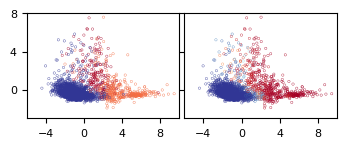

In [10]:
fig = plt.figure(figsize = (4,2), constrained_layout=False)

gs = fig.add_gridspec(4,8)
gs.update(wspace = 0.15, hspace = 1)

ax0 = fig.add_subplot(gs[:3, :4])
ax2 = fig.add_subplot(gs[:3, 4:])

main_data.loc[main_data['artifact']==0, 'class'] = 5
main_data.loc[main_data['hemodynamic']==1, 'class'] = 0
main_data.loc[main_data['movement']==1, 'class'] = 1

colors = np.zeros((len(main_data), 4)) #map type component
for i, ind in enumerate(main_data.index):
    if main_data.loc[ind, 'class'] == 0:
        colors[i] = plt.cm.get_cmap('RdYlBu',6)(0)
    elif main_data.loc[ind, 'class'] == 1:
        colors[i] = plt.cm.get_cmap('RdYlBu',6)(1)
    elif main_data.loc[ind, 'class'] == 5:
        colors[i] = plt.cm.get_cmap('RdYlBu',6)(5)  

ph = ax0.scatter(X_reduced_SVD[:, 0], X_reduced_SVD[:, 1], 
                 facecolors="None",
                 edgecolors=colors,
                 lw=0.25,
                 s = 3)

ax0.set_ylim([-3,8])
ax0.set_xlim([-6,10])
ax0.set_title('')
ax0.set_aspect(1)
ax0.set_xticks([-4,0,4,8])
ax0.set_yticks([0,4,8])


colors = np.zeros((len(main_data), 4))
for i, ind in enumerate(main_data.index): #map average confidence as artifact (red)/neural(blue) of each component
    colors[i] = plt.cm.get_cmap('RdYlBu')(meanbyindex[i])

ph3 = ax2.scatter(X_reduced_SVD[:, 0], X_reduced_SVD[:, 1], 
                 facecolors="None",
                 edgecolors=colors,
                 lw=0.25,
                 s = 3)

ax2.set_ylim(ax0.get_ylim())
ax2.set_xlim(ax0.get_xlim())
ax2.set_yticklabels('')
ax2.set_xticks([-4,0,4,8])
ax2.set_yticks([0,4,8])
ax2.set_aspect(1)

# plt.tight_layout()
if save: 
    plt.savefig('SVD_plots_confidence_OB.svg', dpi = 600)
plt.show()

# print(np.array(hist1)/sum(hist1))
# ---------------------------------------------------------

highest neuro classified:  71.03776255707749  +/-  0.19073683555912008
highest artifact classified:  22.73936073059362  +/-  0.2515228985173231
highest vasc classified:  6.901232876712344  +/-  0.20779131217538147
highest other classified:  15.838127853881236  +/-  0.13423395554637432


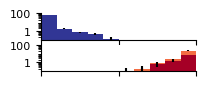

In [11]:
fig, axs = plt.subplots(2,1,figsize=(2,0.75))

allv = len(meanbyindex)
binpos = bin_edges1[:-1] + (bin_edges1[1:] - bin_edges1[:-1])/2
width = (bin_edges1[1:] - bin_edges1[:-1])[0]

axs[0].bar(binpos, np.mean(hist_dist_n/allv*100, axis=0), 
           yerr = np.std(hist_dist_n/allv*100, axis=0), 
           width = width,
            color=plt.cm.get_cmap('RdYlBu',6)(5)
          )
axs[1].bar(binpos,np.mean(hist_dist_v/allv*100, axis=0),
           yerr = np.sqrt(np.std(hist_dist_v/allv*100, axis=0)), 
           width = width,
            color=plt.cm.get_cmap('RdYlBu',6)(0)
          )
bottoms = np.mean(hist_dist_v/allv*100, axis=0)
axs[1].bar(binpos, np.mean(hist_dist_o/allv*100, axis=0),
           yerr = np.std(hist_dist_o/allv*100, axis=0),  
           width = width,
           bottom=bottoms,
            color=plt.cm.get_cmap('RdYlBu',6)(1)
          )

axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
# axs[1].spines['bottom'].set_visible(False)
axs[0].set_ylim(0.1,100)
axs[0].set_xlim([1,0])
axs[0].set_yscale('log')
axs[0].set_yticks([1,100])
axs[0].set_yticklabels([1,100])
axs[0].set_xticks([0,.5,1.00])
axs[0].set_xticklabels([])

axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
# axs[2].spines['bottom'].set_visible(False)
axs[1].set_ylim(0.1,25)
axs[1].set_xlim([1,0])
axs[1].set_yscale('log')
axs[1].set_yticks([1,100])
axs[1].set_yticklabels([1,100])
axs[1].set_xticks([0,.5,1.00])
axs[1].set_xticklabels([])
print('highest neuro classified: ', np.mean(hist_dist_n/allv*100, axis=0)[9], ' +/- ', 
           np.std(hist_dist_n/allv*100, axis=0)[9])
print('highest artifact classified: ', np.mean((hist_dist_v+hist_dist_o)/allv*100, axis=0)[0], ' +/- ', 
           np.std((hist_dist_v+hist_dist_o)/allv*100, axis=0)[0])
print('highest vasc classified: ', np.mean(hist_dist_v/allv*100, axis=0)[0], ' +/- ', 
           np.std(hist_dist_v/allv*100, axis=0)[0])
print('highest other classified: ', np.mean(hist_dist_o/allv*100, axis=0)[0], ' +/- ', 
           np.std(hist_dist_o/allv*100, axis=0)[0])
if save:
    fig.savefig('classifier_performance_mat_hist.svg', dpi=600)
plt.show()

### Visualize NOVEL data performance, based on each animal performace

15000
5000


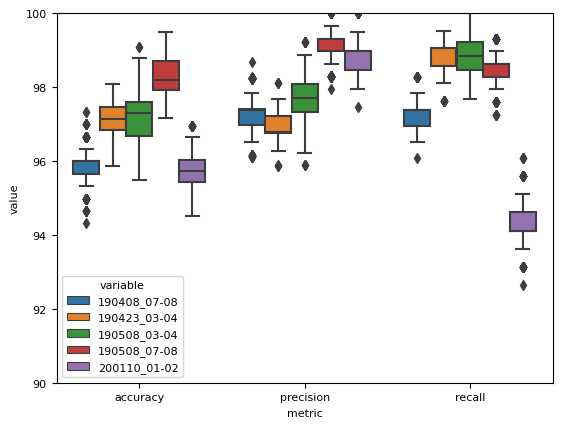

In [12]:
pdf = pd.DataFrame(columns = explist, index = np.arange(iterations))
pdf[:] = prec*100
rdf = pdf.copy()
rdf[:] = reca*100
adf = pdf.copy()
adf[:] = accu*100

pdf = pdf.melt()
pdf['metric'] = 'precision'

rdf = rdf.melt()
rdf['metric'] = 'recall'

adf = adf.melt()
adf['metric'] = 'accuracy'

metric_data = pd.concat([adf, pdf, rdf], ignore_index =True)
print(len(metric_data))
print(len(pdf))

import seaborn as sns
sns.boxplot(x='metric', y='value', hue='variable', data=metric_data)
plt.ylim([90,100])


plt.show()

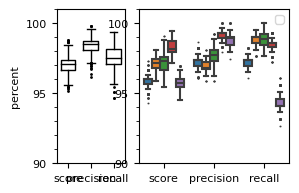

Accuracy mean:  0.9686533280703079
Precision mean:  0.9798869116226597
Recall mean:  0.9757865108416514


In [13]:
data1 = [np.array(score)*100, np.array(precision)*100, np.array(recall)*100]
data2 = [np.array(accu)*100, np.array(prec)*100, np.array(reca)*100]

boxplotprops = {'boxprops':dict(linewidth=1, color='k'), 
    'medianprops':dict(linewidth=1, color='k'), 
    'whiskerprops':dict(linestyle='-', color='k'), 
    'capprops':dict(color='k'),
   'flierprops':dict(markerfacecolor='k', marker='.', linewidth=0.5, markersize = 2)
    }

import matplotlib
colors = matplotlib.cm.get_cmap('tab20c')
import numpy as np

current_class = [96, 97, 96]
fig = plt.figure(figsize=(3,2))

axs0 = plt.subplot2grid((1,3),(0,0))
axs1 = plt.subplot2grid((1,3),(0,1), colspan=2)

axs0.boxplot(data1, widths = 0.65, **boxplotprops)# flierprops=flier)#, boxprops=boxprops, medianprops=medianprops, notch=False, widths=0.75)
axs0.set_ylim([90, 101])
axs0.set_xticklabels(['score', 'precision', 'recall'])
axs0.set_yticks([90, 95, 100])
axs0.set_ylabel('percent')
axs0.minorticks_on()
axs0.tick_params(axis='x', which='minor', bottom=False)

im = sns.boxplot(x='metric', y='value', hue='variable', data=metric_data,
           ax = axs1, fliersize = 0.5)#, palette = grayify_cmap('jet'))

axs1.set_ylim([90, 101])
# ax[1].set_yticks([])
axs1.set_ylabel('')

axs1.minorticks_on()
axs1.set_xticks([0, 1, 2])
axs1.set_xticklabels(['score', 'precision', 'recall'])
plt.legend([])
axs1.set_yticks([90, 95, 100])
axs1.tick_params(axis='x', which='minor', bottom=False)
axs1.set_xlabel('')
for i,box in enumerate(im.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
    box.set_linewidth(1)
    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
        im.lines[j].set_color('black')
        im.lines[j].set_linewidth(1)
# if save:
#     plt.savefig(save_dir+'Novel_data_comparison_20min_Correction.svg', dpi = 600)
plt.show()


print('Accuracy mean: ', np.mean(accu))
print('Precision mean: ', np.mean(prec))
print('Recall mean: ', np.mean(reca))

In [14]:
'''
across training/testing set of animals (classical machine learning where a subset 
components are used to train classification of components of the same dataset)
'''
print('Classical Accuracy mean: ', np.mean(score), ' +/- ', np.std(score))
print('Classical Precision mean: ', np.mean(precision), ' +/- ', np.std(precision))
print('Classical Recall mean: ', np.mean(recall), ' +/- ', np.std(recall))
    
'''
training on other animals and then tested on a NOVEL group of animals
'''
print('\nNovel Accuracy mean: ', np.mean(accu), ' +/- ', np.std(accu))
print('Novel Precision mean: ', np.mean(prec), ' +/- ', np.std(prec))
print('Novel Recall mean: ', np.mean(reca), ' +/- ', np.std(reca))

Classical Accuracy mean:  0.9707914764079149  +/-  0.005796249660551339
Classical Precision mean:  0.9841390600896631  +/-  0.0054421010062119515
Classical Recall mean:  0.9762880658436214  +/-  0.0070541701760326115

Novel Accuracy mean:  0.9686533280703079  +/-  0.010430200827960165
Novel Precision mean:  0.9798869116226597  +/-  0.01009296487049909
Novel Recall mean:  0.9757865108416514  +/-  0.01786013781869226


In [24]:
novel_results.loc[novel_results['percent']==novel_results['neural'] ,'alwaysTP_TN'] = 1 #HIGHLY confident true positive/negative
novel_results.loc[novel_results['percent']==novel_results['artifact'] ,'alwaysFP_FN'] = 1 
novel_results.loc[novel_results['percent']==0 ,'alwaysTN_FN'] = 1 #HIGLY confident true negative/false negative
novel_results.loc[novel_results['percent']==1 ,'alwaysTP_FP'] = 1 #HIGLY confident true positive/false positive

novel_results['rounded_all'] = np.round(novel_results['percent']) #based on confidence, how would the model assign class
novel_results.loc[novel_results['rounded_all']==novel_results['neural'] ,'TP_TN'] = 1 #HIGHLY confident true positive/negative
novel_results.loc[novel_results['rounded_all']==novel_results['artifact'] ,'FP_FN'] = 1 #HIGHLY confident true positive/negative
novel_results.loc[novel_results['rounded_all']==0 ,'TN_FN'] = 1 #HIGLY confident true negative/false negative
novel_results.loc[novel_results['rounded_all']==1 ,'TP_FP'] = 1 #HIGLY confident true positive/false positive

novel_data.loc[novel_data['hemodynamic']==1, 'class'] = 'v' #define the types of class
novel_data.loc[novel_data['movement']==1, 'class'] = 'o'
novel_data.loc[novel_data['artifact']==0, 'class'] = 'n'
novel_results['class'] = novel_data['class']

print('Overall correct: {}%'.format(
    np.round(np.nansum(novel_results['TP_TN'])/len(novel_results)*100, 2)))
print('Overall incorrect: {}%'.format(
    np.round(np.nansum(novel_results['FP_FN'])/len(novel_results)*100, 2)))

print('\nOverall HIGHLY confident and correct: {}%'.format(
    np.round(np.nansum(novel_results['alwaysTP_TN'])/len(novel_results)*100, 2)))
print('Overall HIGHLY confident and incorrect: {}%'.format(
    np.round(np.nansum(novel_results['alwaysFP_FN'])/len(novel_results)*100, 2)))

for c in ['n','v','o']:
    print('\nClass type: ', c)
    index = novel_results[novel_results['class']==c].index
    print('Class correct: {0}% {1}/{2}'.format(
        np.round(np.nansum(novel_results.loc[index, 'TP_TN'])/len(index)*100, 2),
        np.nansum(novel_results.loc[index, 'TP_TN']),len(index)))
    print('Class incorrect: {0}% {1}/{2}'.format(
        np.round(np.nansum(novel_results.loc[index, 'FP_FN'])/len(index)*100, 2),
        np.nansum(novel_results.loc[index, 'FP_FN']),len(index)))

Overall correct: 96.93%
Overall incorrect: 3.07%

Overall HIGHLY confident and correct: 92.41%
Overall HIGHLY confident and incorrect: 0.84%

Class type:  n
Class correct: 97.66% 1167.0/1195
Class incorrect: 2.34% 28.0/1195

Class type:  v
Class correct: 93.48% 129.0/138
Class incorrect: 6.52% 9.0/138

Class type:  o
Class correct: 95.73% 314.0/328
Class incorrect: 4.27% 14.0/328


In [16]:
animals = np.unique(novel_data['anml'])
n_components = np.zeros((len(animals)))

for i, anml in enumerate(animals):
    animal = novel_data[novel_data['anml']==anml]
#     n_components[i] = int(animal.index[-1][-4:])
    n_components[i] = len(animal)
    for n, j in enumerate(animal.index[::-1]):
        novel_data.loc[j,'var_pos'] = int(j[-3:])
        novel_data.loc[j,'rel_pos'] = int(j[-3:])/n_components[i]

190408_07-08
190423_03-04
190508_03-04
190508_07-08
200110_01-02


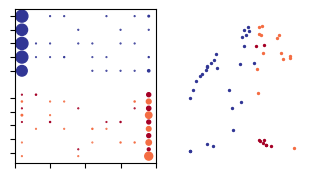

In [17]:
novel_data['region_centroid_1_ud'] = (novel_data['region_centroid_1']-np.max(novel_data['region_centroid_1'])/2)*6.75/1000
novel_data['region_centroid_0_ud'] = novel_data['region_centroid_0']*6.75/1000

fig, axs = plt.subplots(1,2,figsize=(4,2))


for i, a in enumerate(nanimals):
    subset = novel_data[novel_data['anml']==a].copy()
    result = novel_results[novel_results['anml']==a].copy()
    print(subset.index[0][:12])
    if i ==0:
        binn = 10
        P = np.histogram(result.loc[subset['class']=='n', 'percent'],binn)
        bins = P[1]
        binpos = P[1][:-1]+(P[1][1:]-P[1][:-1])/2
        per_val = np.zeros((len(nanimals),3,binn))

    else:
        P = np.histogram(result.loc[subset['class']=='n', 'percent'],bins)
    axs[0].scatter(binpos, np.ones(len(P[0]))*-i*2, s = P[0]/len(subset)*100, color=plt.cm.get_cmap('RdYlBu',6)(5))
    per_val[i,0] = P[0]
    N = np.histogram(result.loc[(subset['class']=='v'), 'percent'],bins=bins)
    axs[0].scatter(binpos, np.ones(len(N[0]))*-1*i*2-11.5, s = N[0]/len(subset)*100, color=plt.cm.get_cmap('RdYlBu',6)(0))
    per_val[i,1] = N[0]
    N = np.histogram(result.loc[subset['class']=='o', 'percent'],bins=P[1])
    axs[0].scatter(binpos, np.ones(len(N[0]))*-1*i*2-12.5, s = N[0]/len(subset)*100, color= plt.cm.get_cmap('RdYlBu',6)(1))
    per_val[i,2] = N[0]
axs[0].set_xlim(1,0)
axs[0].set_yticks([0,-2,-4,-6,-8,-12,-14,-16,-18,-20])
axs[0].set_yticklabels([])
axs[0].set_xticklabels([])


axs[1].scatter(np.abs(novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='n'), 'region_centroid_1_ud']),
            novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='n'), 'region_centroid_0_ud'],
           color=plt.cm.get_cmap('RdYlBu',6)(5), s=2)
axs[1].scatter(-1*np.abs(novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='v'), 'region_centroid_1_ud']),
            novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='v'), 'region_centroid_0_ud'],
           color=plt.cm.get_cmap('RdYlBu',6)(0), s=2)
axs[1].scatter(-1*np.abs(novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='o'), 'region_centroid_1_ud']),
            novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='o'), 'region_centroid_0_ud'],
           color=plt.cm.get_cmap('RdYlBu',6)(1), s=2)

axs[1].set_xlim(novel_data['region_centroid_1_ud'].max()+0.5,novel_data['region_centroid_1_ud'].min()-0.5)
axs[1].set_ylim(novel_data['region_centroid_0_ud'].min()-0.5, novel_data['region_centroid_0_ud'].max()+0.5)
axs[1].set_aspect(1)
axs[1].axis('off')
plt.savefig('Novel_data_comparison_confusion_mat_loc_OB.svg', dpi = 600)
plt.show()

69.65683323299217
1.9780151846411864
highest neuro classified:  69.65683323299217  +/-  1.9780151846411866
highest artifact classified:  25.82781456953642  +/-  1.3709760700773301
highest vascular classified:  7.525586995785671  +/-  0.35515668160752856
highest other classified:  18.302227573750756  +/-  1.5830057487821598


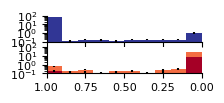

In [18]:
plt.rcParams['font.size'] = 8
fig, axs = plt.subplots(2,1,figsize=(2,0.75))

print(np.max(np.sum(per_val[:,0,:], axis = 0)/np.sum(per_val)*100))
print(np.std(per_val[:,0,:]/np.sum(per_val)*100, axis = 0)[-1])

# axs[0].bar(binpos, np.sum(per_val[:,0,:], axis = 0)/np.sum(per_val)*100, width = 0.1,
#            yerr =  np.std(per_val[:,0,:]/np.sum(per_val)*100, axis = 0),
#            color=plt.cm.get_cmap('RdYlBu',6)(5))
axs[0].bar(binpos, np.sum(per_val[:,0,:], axis = 0)/np.sum(per_val)*100, width = 0.1,
           yerr =  np.std(per_val[:,0,:]/np.sum(per_val)*100, axis = 0),
           color=plt.cm.get_cmap('RdYlBu',6)(5))
axs[1].bar(binpos, np.sum(per_val[:,1,:], axis = 0)/np.sum(per_val)*100, width = 0.1,
           yerr =  np.std(per_val[:,1,:]/np.sum(per_val)*100, axis = 0),
           color=plt.cm.get_cmap('RdYlBu',6)(0))
bottoms = np.sum(per_val[:,1,:], axis = 0)/np.sum(per_val)*100
axs[1].bar(binpos, np.sum(per_val[:,2,:], axis = 0)/np.sum(per_val)*100, width = 0.1, 
           yerr =  np.std(per_val[:,2,:]/np.sum(per_val)*100, axis = 0),
           bottom=bottoms,
        color=plt.cm.get_cmap('RdYlBu',6)(1))

print('highest neuro classified: ', np.sum(per_val[:,0,9], axis = 0)/np.sum(per_val)*100, ' +/- ', 
           np.std(per_val[:,0,9], axis = 0)/np.sum(per_val)*100)
print('highest artifact classified: ', np.sum(per_val[:,1,0] + per_val[:,2,0], axis = 0)/np.sum(per_val)*100, ' +/- ', 
           np.std(per_val[:,1,0] + per_val[:,2,0], axis = 0)/np.sum(per_val)*100)
print('highest vascular classified: ', np.sum(per_val[:,1,0], axis = 0)/np.sum(per_val)*100, ' +/- ', 
           np.std(per_val[:,1,0], axis = 0)/np.sum(per_val)*100)
print('highest other classified: ', np.sum(per_val[:,2,0], axis = 0)/np.sum(per_val)*100, ' +/- ', 
           np.std(per_val[:,2,0], axis = 0)/np.sum(per_val)*100)

axs[0].set_xticklabels([])
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
# axs[1].spines['bottom'].set_visible(False)
axs[0].set_ylim(0.1,100)
axs[0].set_xlim([1,0])
axs[0].set_yscale('log')

axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
# axs[2].spines['bottom'].set_visible(False)
axs[1].set_ylim(.1,100)
axs[1].set_xlim([1,0])
axs[1].set_yscale('log')

if save:
    fig.savefig('classifier_performance_mat_novel_hist.svg', dpi=600)
plt.show()
